In [140]:
import torch
from Annealing_Flow_Langevin import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
from pytensor.tensor import TensorVariable
from scipy.stats import multivariate_normal, uniform
import math

In [141]:
# mau
def sampleNormal(mean, cov):
    """
    mean: mean vector of dimension (d,)
    cov: covariance metrix of dimension (d,d)
    Returns a sample from an n-dimensional multivariate normal distribution and its log probability
    """
    rv = multivariate_normal(mean, cov)
    sample = rv.rvs()
    return sample
def getGMMPdf(means, covs, mixture_weights=None):
    """
    means: list of (d,) arrays
    covs: list of (d,d) arrays
    returns: pdf function
    """
    if mixture_weights is None:
        mixture_weights = [1/len(means)]*len(means)
    assert len(means) == len(covs) == len(mixture_weights)
    def pdf(pos):
        """
        pos: (n,d) array of points to evaluate the PDF at
        returns: (n,) array of floats
        """
        assert pos.shape[1] == means[0].shape[0]
        result = np.zeros((pos.shape[0],))
        for idx, mean in enumerate(means):
            rv = multivariate_normal(mean, covs[idx])
            result += mixture_weights[idx]*rv.pdf(pos)
        return result
    return pdf

# Function to generate a radially symmetric 2D GMM PDF with n modes of variance var
def getRadGMM2D(n, r, var):
    angles = np.linspace(0, 2*np.pi*((n-1)/n),n)
    return getGMMPdf(np.array([np.array([r*np.cos(ang),r*np.sin(ang)]) for ang in angles]),n*[var*np.eye(2)])

# Function to generate a symmetric truncated 2D-Gaussian PDF of dimension d with truncation radius c
def getTruncatedGaussian2D(c, var=1):
    """
    c: truncation radius
    returns: pdf function
    """
    normalizing_constant = 2*np.pi*var*np.exp(-c**2/(2*var))


    def pdf(x):
        """
        x: (n,2) array of points to evaluate the PDF at
        returns: (n,) array of floats
        """
        unnormalized_pdf = np.exp(-np.linalg.norm(x, axis=1)**2/(2*var))
        pdf_val = unnormalized_pdf / normalizing_constant
        return np.where(np.linalg.norm(x, axis=1) < c, 0, pdf_val)
    return pdf

def effective_sample_size(weights):
    """
    weights: (n,) array
    returns: (1,) array
    """
    return np.sum(weights)**2/np.sum(weights**2)

In [142]:
def getUnnormalizedIntermediate(beta, initial, target, compose_type="exp"):
    """
    beta: float
    initial: pdf of initial distribution
    target: pdf of target distribution
    returns: unnormalized pdf of intermediate distribution
    """
    def unnormalizedPdf(x):
        """
        x: (n,d) array
        returns: (n,) array
        """
        if compose_type == "lin":
            return initial(x) + beta*(target(x) - initial(x))
        if compose_type == "exp":
            return initial(x)**(1-beta)*target(x)**beta
    return unnormalizedPdf

def gaussianDriftMH(samples, beta, initial, target, var=0.1, compose_type="exp"):
    """
    samples: (n,d) array
    beta: float
    initial: pdf of initial distribution
    target: pdf of target distribution
    returns: (n,d) array
    """
    samples = samples.clone()
    n, d = samples.shape
    new_samples = np.apply_along_axis(lambda x: sampleNormal(x, var * np.eye(x.shape[0])), 1, samples).reshape((n, d))
    pdf = getUnnormalizedIntermediate(beta, initial, target, compose_type)
    old_probs = pdf(samples)
    new_probs = pdf(new_samples)
    rv = uniform()
    u = rv.rvs((samples.shape[0],))
    aux = u < new_probs/old_probs
    new_samples = torch.tensor(new_samples, dtype=torch.float32)
    samples[aux] = new_samples[aux]
    return samples
# mau
def intermediateTransition(samples, beta, initial, target, k=5, transition_var=0.1, compose_type="exp"):
    """
    sample: (n,d) array
    beta: float
    initial: pdf of initial distribution
    target: pdf of target distribution
    returns: (n,d) array
    """
    for i in range(k):
        samples = gaussianDriftMH(samples, beta, initial, target, transition_var, compose_type)
    return samples
# mau
def AIS(beta_schedule, target, init_mean=np.array([0]), init_var=np.array([1]), n=2, k=5, transition_var=0.1, compose_type="exp"):
    """
    beta_schedule: list of floats from 0.0 to 1.0
    target: pdf of target distribution
    init_mean: (d,) array
    init_var: (d,d) array
    returns: (n,d) array and weight
    """
    rv = multivariate_normal(init_mean, init_var)
    initial = rv.pdf
    d = init_mean.shape[0]
    samples = torch.tensor(rv.rvs(n).reshape((n,d)), dtype=torch.float32)
    all_samples = [samples]
    log_weights = -np.log(initial(samples))

    for beta in beta_schedule[1:-1]:
        intermediate_pdf = getUnnormalizedIntermediate(beta, initial, target, compose_type)
        log_weights += np.log(intermediate_pdf(samples))
        samples = intermediateTransition(samples, beta, initial, target, k, transition_var, compose_type)
        all_samples.append(samples)
        log_weights -= np.log(intermediate_pdf(samples))
    
    intermediate_pdf = getUnnormalizedIntermediate(beta_schedule[-1], initial, target, compose_type)
    log_weights += np.log(intermediate_pdf(samples))
    return samples, np.exp(log_weights), all_samples

In [257]:
config = Namespace(hid_dims = "32-32", Xdim_flow = 2)
def FlowAIS(beta_schedule, target, init_mean=np.array([0]), init_var=np.array([1]), n=2, k=5, transition_var=0.1, compose_type="exp", flow_network_paths=None):
    """
    beta_schedule: list of floats from 0.0 to 1.0
    target: pdf of target distribution
    init_mean: (d,) array
    init_var: (d,d) array
    returns: (n,d) array and weight
    """
    rv = multivariate_normal(init_mean, init_var)
    initial = rv.pdf
    d = init_mean.shape[0]
    samples = torch.tensor(rv.rvs(n).reshape((n,d)), dtype=torch.float32)
    all_samples = [samples]
    log_weights = -np.log(initial(samples))
    log_weights = torch.tensor(log_weights, dtype=torch.float32)

    for idx, beta in enumerate(beta_schedule[1:-1]):
        filepath = flow_network_paths[idx]
        checkpt = torch.load(filepath, map_location=torch.device('cpu'), weights_only=False)
        model = default_CNF_structure(config)
        model.load_state_dict(checkpt['model'])
        ls_arg_CNF = checkpt['ls_args_CNF']
        samples, _ = FlowNet_forward(samples, model, ls_arg_CNF, idx+1)
        intermediate_pdf = getUnnormalizedIntermediate(beta, initial, target, compose_type)
        log_weights += np.log(intermediate_pdf(samples))
        samples = intermediateTransition(samples, beta, initial, target, k, transition_var, compose_type)
        all_samples.append(samples)
        log_weights -= np.log(intermediate_pdf(samples))
    
    intermediate_pdf = getUnnormalizedIntermediate(beta_schedule[-1], initial, target, compose_type)
    log_weights += np.log(intermediate_pdf(samples))
    return samples, np.exp(log_weights), all_samples

In [258]:
target = getTruncatedGaussian2D(3)
initial = multivariate_normal(np.array([0,0]), np.eye(2)).pdf
beta_schedule = np.array([i/8 for i in range(16)])
beta_schedule = np.clip(beta_schedule, 0, 1)
flow_network_paths = [f"samplers_trained_Langevin/d=2_GMM_sphere_c=8/block{i}.pth" for i in range(1,16)]

In [259]:
samples, weights, all_samples = FlowAIS(beta_schedule=beta_schedule, target=target, init_mean=np.array([0,0]), init_var=np.eye(2), n=1000, k=20, transition_var=0.1, flow_network_paths=flow_network_paths)

/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/2705557088.py:26: RuntimeWarning: divide by zero encountered in log
  log_weights += np.log(intermediate_pdf(samples))
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/2705557088.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_weights += np.log(intermediate_pdf(samples))
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/2858433841.py:35: RuntimeWarning: divide by zero encountered in divide
  aux = u < new_probs/old_probs
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/2858433841.py:35: RuntimeWarning: invalid value encountered in divide
  aux = u < new_probs/old_probs
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/2858433841.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone()

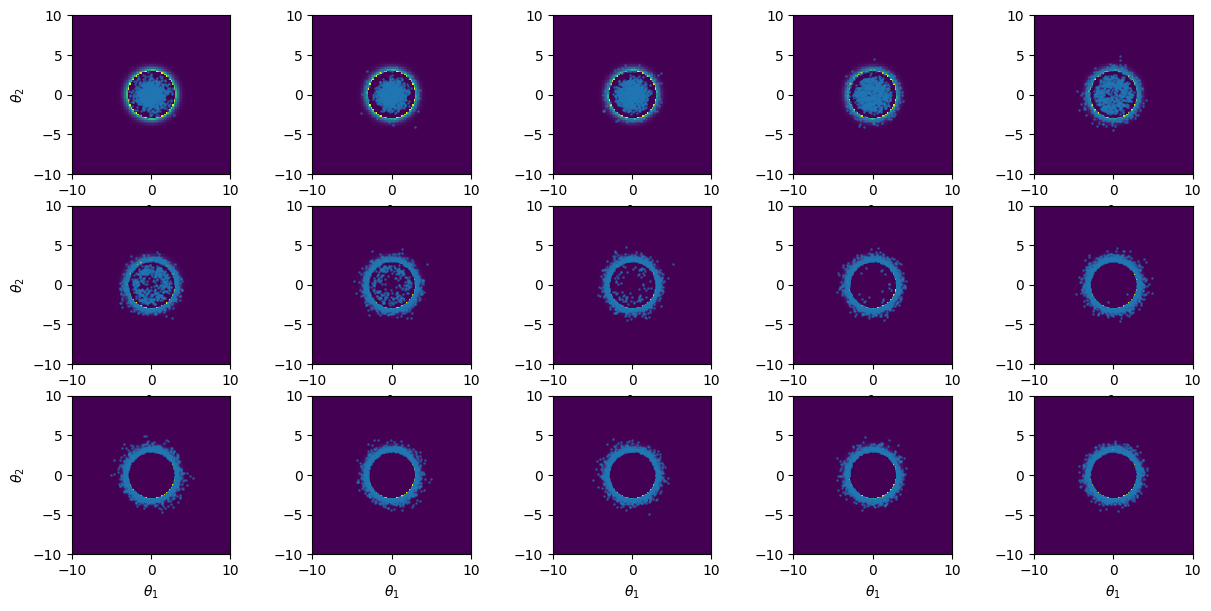

In [260]:
x_coords = np.linspace(-10, 10, 100)
y_coords = np.linspace(-10, 10, 100)
xs = np.array([[x, y] for y in y_coords for x in x_coords])
ys = target(xs)
nrows = 3
ncols = 5
fig, axs = plt.subplots(nrows, ncols, figsize=(15,7))
for idx, beta in enumerate(beta_schedule[:-1]):
    row = idx // ncols
    col = idx % ncols
    ax = axs[row, col]
    # pdf = getUnnormalizedIntermediate(beta, initial, target)
    pdf = target
    ax.imshow(pdf(xs).reshape(100,100), extent=(-10, 10, -10, 10), interpolation='nearest')
    points = all_samples[idx].detach().numpy()
    ax.scatter(points[:,0], points[:,1], alpha=0.5, s=1)
    ax.set_xlabel(r"$\theta_1$")
    if col == 0:
        ax.set_ylabel(r"$\theta_2$")

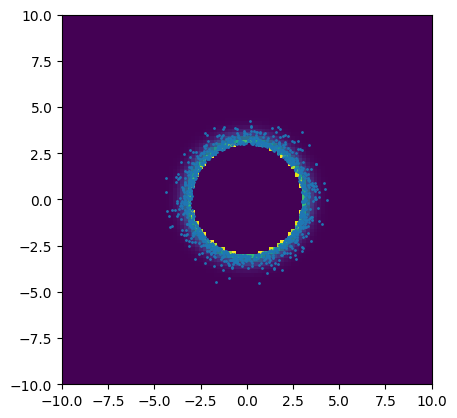

In [261]:
plt.imshow(target(xs).reshape((100,100)), extent=(-10, 10, -10, 10), interpolation='nearest')
plt.scatter(samples[:,0], samples[:,1], s=1)


In [251]:
target = getTruncatedGaussian2D(3)
initial = multivariate_normal(np.array([0,0]), np.eye(2)).pdf
beta_schedule = np.array([i/8 for i in range(16)])
beta_schedule = np.clip(beta_schedule, 0, 1)
flow_network_paths = [f"samplers_trained_Langevin/d=2_truncated_c=3/block{i}.pth" for i in range(1,16)]

In [252]:
samples, weights, all_samples = FlowAIS(beta_schedule=beta_schedule, target=target, init_mean=np.array([0,0]), init_var=np.eye(2), n=1000, k=50, transition_var=0.1, flow_network_paths=flow_network_paths)

/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/1320823405.py:26: RuntimeWarning: divide by zero encountered in log
  log_weights += np.log(intermediate_pdf(samples))
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/1320823405.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_weights += np.log(intermediate_pdf(samples))
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/1320823405.py:29: RuntimeWarning: divide by zero encountered in log
  log_weights -= np.log(intermediate_pdf(samples))
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/1320823405.py:29: RuntimeWarning: invalid value encountered in subtract
  log_weights -= np.log(intermediate_pdf(samples))
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/1320823405.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally

Text(0, 0.5, '$\\theta_2$')

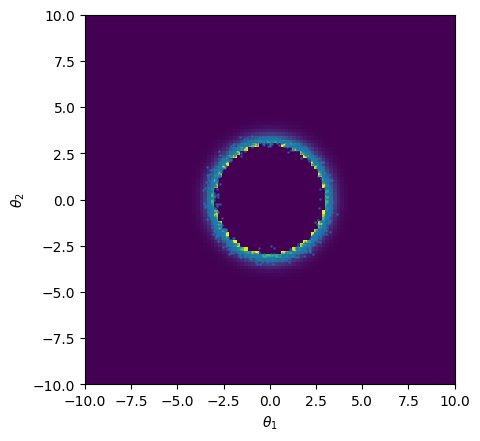

In [253]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=1)
plt.imshow(target(xs).reshape(100,100), extent=(-10, 10, -10, 10), interpolation='nearest')
# plt.title("Truncated Gaussian with correct flow (no MCMC)")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")

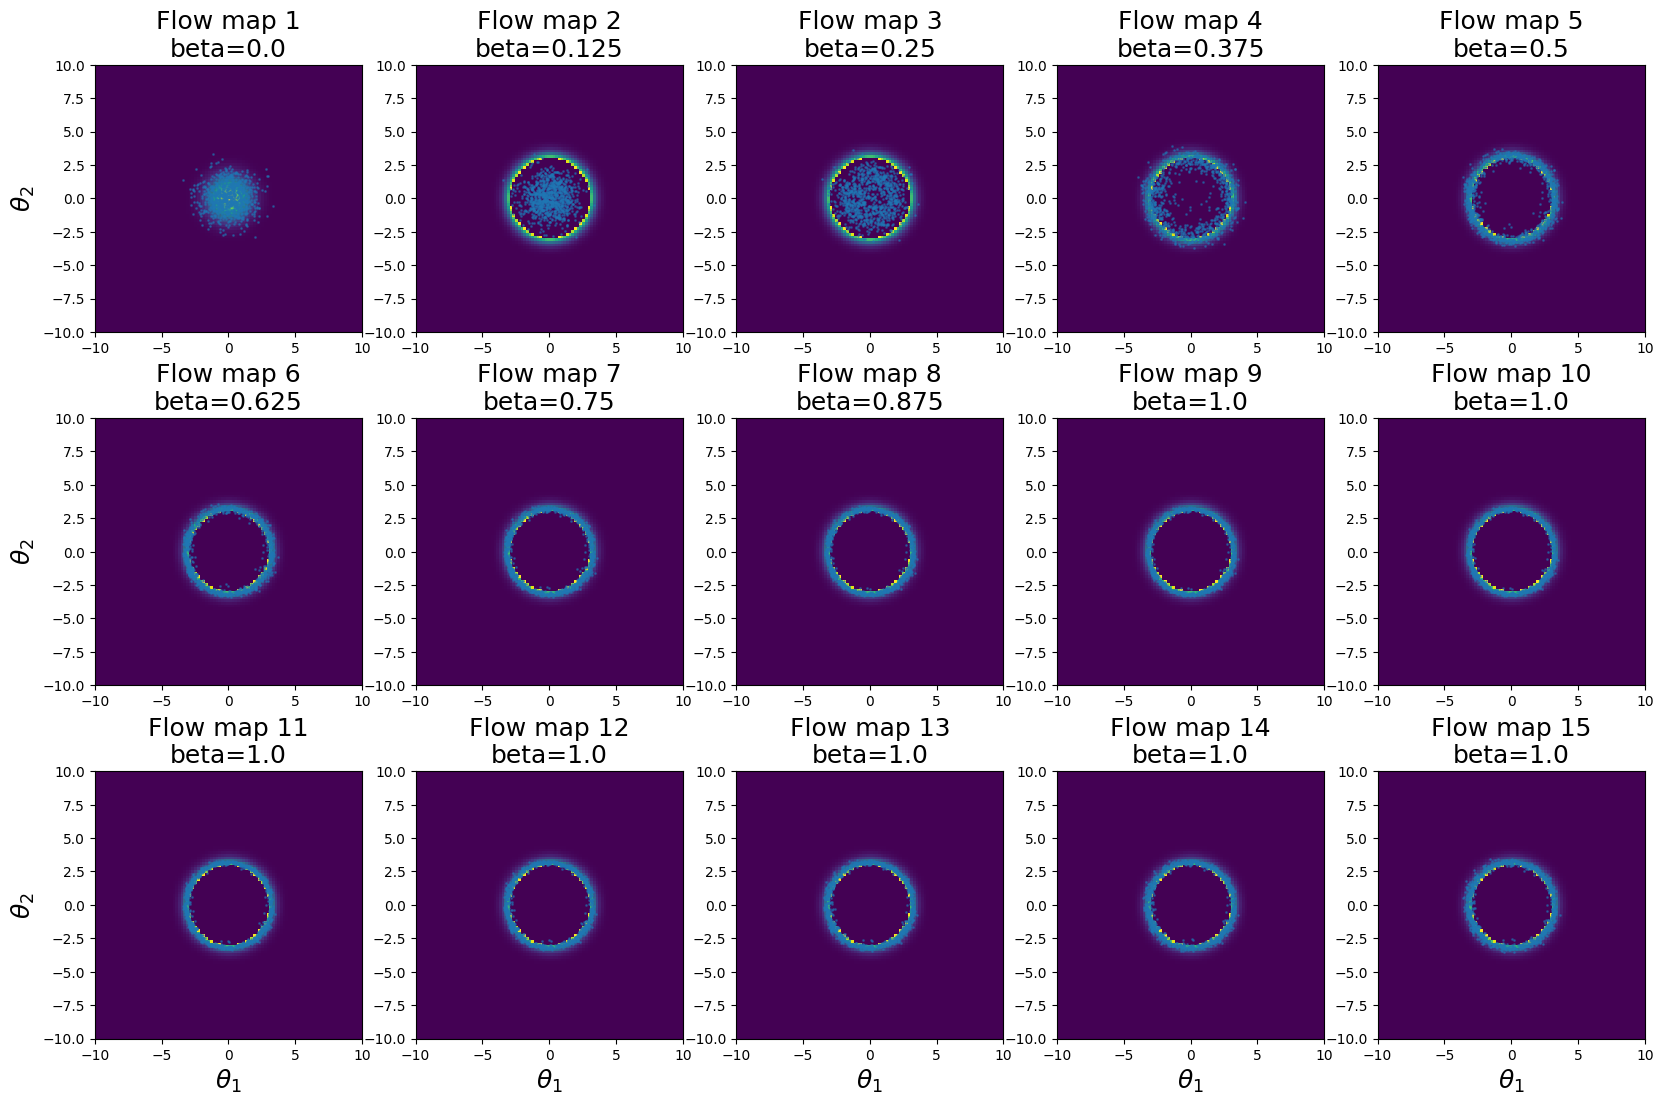

In [256]:
x_coords = np.linspace(-10, 10, 100)
y_coords = np.linspace(-10, 10, 100)
xs = np.array([[x, y] for y in y_coords for x in x_coords])
ys = target(xs)
nrows = 3
ncols = 5
fig, axs = plt.subplots(nrows, ncols, figsize=(20,13))
for idx, beta in enumerate(beta_schedule[:-1]):
    row = idx // ncols
    col = idx % ncols
    ax = axs[row, col]
    pdf = getUnnormalizedIntermediate(beta, initial, target)
    ax.imshow(pdf(xs).reshape(100,100), extent=(-10, 10, -10, 10), interpolation='nearest')
    points = all_samples[idx].detach().numpy()
    ax.scatter(points[:,0], points[:,1], alpha=0.5, s=1)
    ax.set_title(f"Flow map {idx+1}\nbeta={beta}", fontsize=18)
    if row == nrows-1:
        ax.set_xlabel(r"$\theta_1$", fontsize=18)
    if col == 0:
        ax.set_ylabel(r"$\theta_2$", fontsize=18)
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    

In [264]:
target = getRadGMM2D(6, 8, 1)
initial = multivariate_normal(np.array([0,0]), np.eye(2)).pdf
beta_schedule = np.array([i/8 for i in range(16)])
beta_schedule = np.clip(beta_schedule, 0, 1)
config = Namespace(hid_dims = "32-32", Xdim_flow = 2)
flow_network_paths = [f"samplers_trained_Langevin/d=2_GMM_sphere_c=8/block{i}.pth" for i in range(1,16)]

In [265]:
samples, weights, all_samples = FlowAIS(beta_schedule=beta_schedule, target=target, init_mean=np.array([0,0]), init_var=np.eye(2), n=1000, k=20, flow_network_paths=flow_network_paths)

/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/2705557088.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_weights += np.log(intermediate_pdf(samples))
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/2858433841.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_samples = torch.tensor(new_samples, dtype=torch.float32)
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/2705557088.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_weights -= np.log(intermediate_pdf(samples))
/var/folders/wr/y7_47vk12rj6g2068bxysgjc0000gn/T/ipykernel_3560/2705557088.py:32: DeprecationWarning: __array_wrap__ must

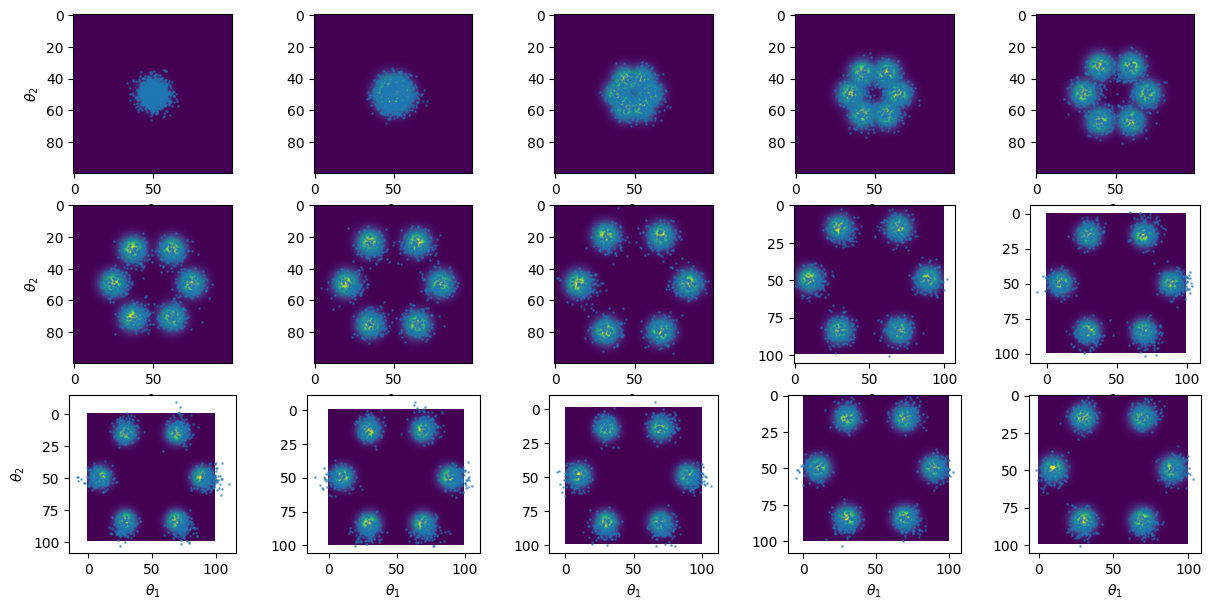

In [266]:
x_coords = np.linspace(-10, 10, 100)
y_coords = np.linspace(-10, 10, 100)
xs = np.array([[x, y] for y in y_coords for x in x_coords])
ys = target(xs)
nrows = 3
ncols = 5
fig, axs = plt.subplots(nrows, ncols, figsize=(15,7))
for idx, beta in enumerate(beta_schedule[:-1]):
    row = idx // ncols
    col = idx % ncols
    ax = axs[row, col]
    pdf = getUnnormalizedIntermediate(beta, initial, target)
    ax.imshow(pdf(xs).reshape(100,100))
    points = all_samples[idx].detach().numpy()
    ax.scatter(points[:,0]*5+50, points[:,1]*5+50, alpha=0.5, s=1)
    ax.set_xlabel(r"$\theta_1$")
    if col == 0:
        ax.set_ylabel(r"$\theta_2$")

Text(0, 0.5, '$\\theta_2$')

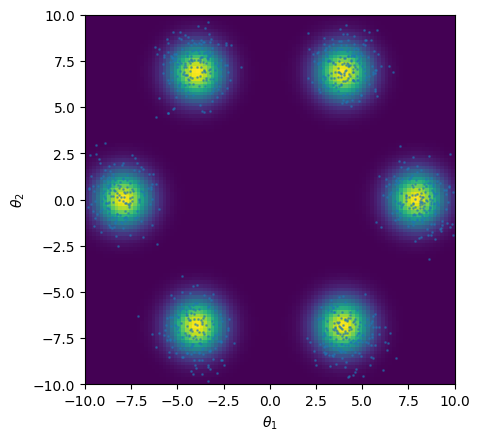

In [267]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=1)
plt.imshow(target(xs).reshape(100,100), extent=(-10, 10, -10, 10), interpolation='nearest')
# plt.title("Truncated Gaussian with correct flow (no MCMC)")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")

In [268]:
x_coords = np.linspace(-10, 10, 40)
y_coords = np.linspace(-10, 10, 40)
xs = torch.tensor([[x, y] for y in y_coords for x in x_coords], dtype=torch.float32).to(device)
# xs = torch.tensor(np.random.normal(0, 1, (1000, 2)), dtype=torch.float32).to(device)
all_xs = [xs]
for i in range(1, 15):
    filepath = f"samplers_trained_Langevin/d=2_truncated_c=3/block{i}.pth"
    checkpt = torch.load(filepath, map_location=torch.device('cpu'), weights_only=False)
    model = default_CNF_structure(config)
    model.load_state_dict(checkpt['model'])
    ls_args_CNF = checkpt['ls_args_CNF']
    xs, px = FlowNet_forward(xs.to(device), model, ls_args_CNF, i)
    all_xs.append(xs)

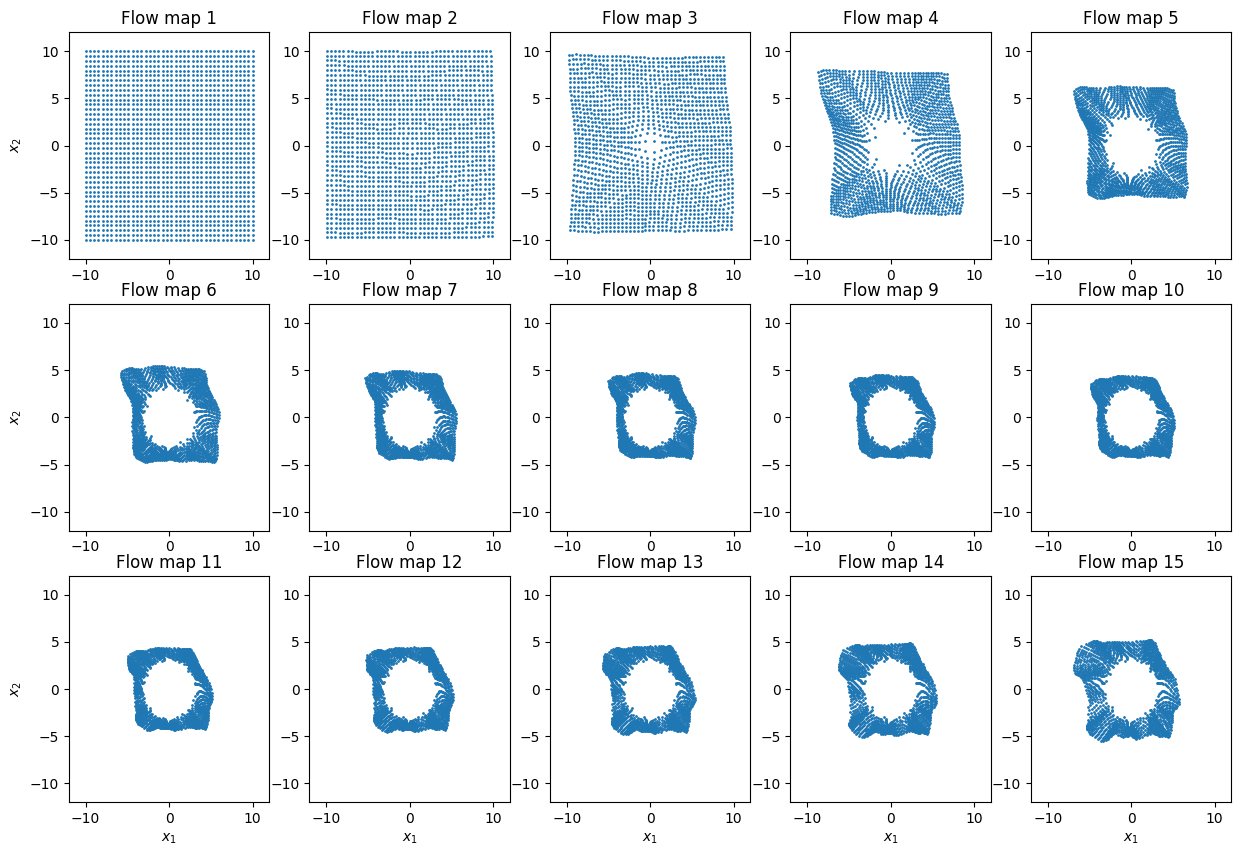

In [208]:
nrow = 3
ncol = 5
fig, axs = plt.subplots(nrow,ncol, figsize=(15,10))
for idx, xs in enumerate(all_xs):
    row = idx // ncol
    col = idx % ncol
    ax = axs[row, col]
    ax.scatter(xs[:, 0].detach().numpy(), xs[:, 1].detach().numpy(), s=1)
    ax.set_xlim(-12, 12)
    ax.set_ylim(-12, 12)
    ax.set_title(f"Flow map {idx+1}")
    if row == nrow-1:
        ax.set_xlabel(r"$x_1$")
    if col == 0:
        ax.set_ylabel(r"$x_2$")

In [129]:
config = Namespace(hid_dims = "32-32", Xdim_flow = 2)

In [209]:
x_coords = np.linspace(-10, 10, 30)
y_coords = np.linspace(-10, 10, 30)
xs = torch.tensor([[x, y] for y in y_coords for x in x_coords]).to(torch.float32).to(device)
# xs = torch.tensor(np.random.normal(0, 1, (1000, 2)), dtype=torch.float32).to(device)
all_xs = [xs]
for i in range(1, 15):
    filepath = f"samplers_trained_Langevin/d=2_GMM_sphere_c=8/block{i}.pth"
    checkpt = torch.load(filepath, map_location=torch.device('cpu'), weights_only=False)
    model = default_CNF_structure(config)
    model.load_state_dict(checkpt['model'])
    ls_args_CNF = checkpt['ls_args_CNF']
    xs, px = FlowNet_forward(xs.to(device), model, ls_args_CNF, i)
    all_xs.append(xs)


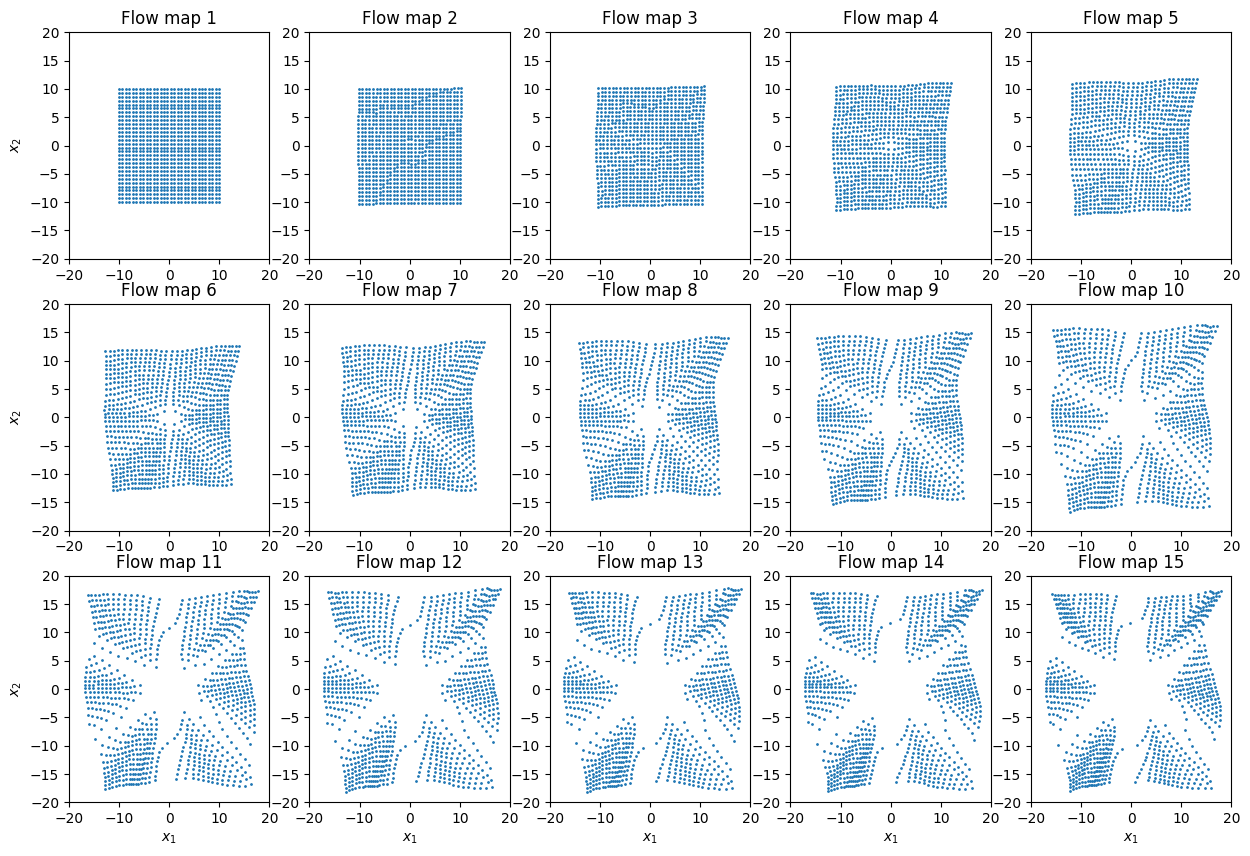

In [210]:
nrow = 3
ncol = 5
fig, axs = plt.subplots(nrow,ncol, figsize=(15,10))
for idx, xs in enumerate(all_xs):
    row = idx // ncol
    col = idx % ncol
    ax = axs[row, col]
    ax.scatter(xs[:, 0].detach().numpy(), xs[:, 1].detach().numpy(), s=1)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_title(f"Flow map {idx+1}")
    if row == nrow-1:
        ax.set_xlabel(r"$x_1$")
    if col == 0:
        ax.set_ylabel(r"$x_2$")